In [1]:
from modules.data_types import Transmission
from modules.utils import auto_colormap, HdfTools
from modules.emd import emd_1d
from typing import *
from matplotlib import pyplot as plt
from matplotlib import gridspec
from seaborn import heatmap
from itertools import product
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [2]:
# Load data
# This is the same data used to create the plot in Fig 2d
# It is also the same as the plot data file saved in the "cell_types" Mesmerize project
t = Transmission.from_hdf5('./data/hier_clustering_all_promoters.ptrn')
cluster_labels = t.df.FCLUSTER_LABELS.unique()
cluster_labels.sort()

Load precomputed center-likes

In [3]:
center_likes = HdfTools.load_dict('./data/centerlikes.h5', 'data')
center_like_dfts = HdfTools.load_dict('./data/centerlikes_dfts.h5', 'data')

In [4]:
# Centerlike function from mesmerize
def get_centerlike(cluster_members: np.ndarray, 
                   metric: Optional[Union[str, callable]] = None,
                   dist_matrix: Optional[np.ndarray] = None, 
                   n_jobs: int = 16
                  ) -> Tuple[np.ndarray, int]:
    """
    Finds the 1D time-series within a cluster that is the most centerlike

    :param cluster_members: 2D numpy array in the form [n_samples, 1D time_series]
    :param metric:          Metric to use for pairwise distance calculation, simply passed to sklearn.metrics.pairwise_distances
    :param dist_matrix:     Distance matrix of the cluster members

    :return:                The cluster member which is most centerlike, and its index in the cluster_members array
    """
    if dist_matrix is None:
        dist_matrix = pairwise_distances(cluster_members, metric=metric, n_jobs=n_jobs)

    c_ix = np.argmin(np.sum(dist_matrix, axis=0))
    c = cluster_members[c_ix, :]
    return c, c_ix

Or recompute the centerlikes by setting the following cell to "code" instead of "raw"

In [5]:
# Convert the keys from str as present in the HDF5 file back to ints
for k in list(center_likes.keys()):
    center_likes[int(k)] = center_likes.pop(k)

for k in list(center_like_dfts.keys()):
    center_like_dfts[int(k)] = center_like_dfts.pop(k)

# Fig 4b

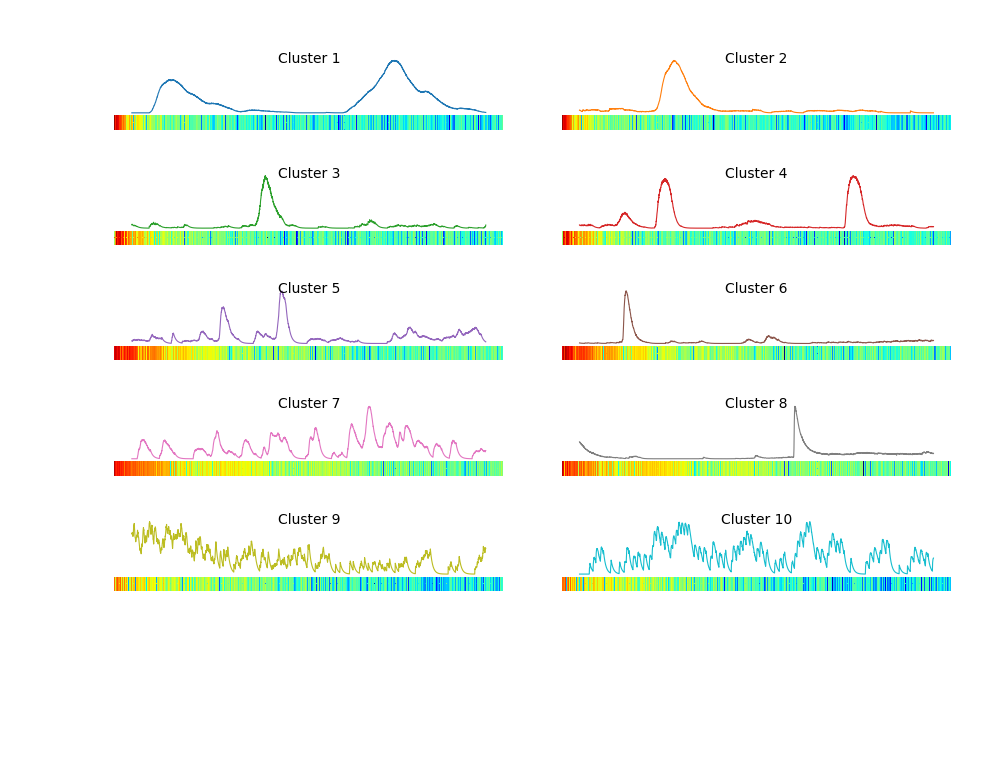

In [6]:
# Draw the centerlikes with the time-domain plotted as trace over a band illustrating the frequency domain of the same data.
nrows = (4 * 10) + 4
ncols = 2

fig = plt.figure(figsize=(2.7, 2.1), dpi=400)
gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.15, hspace=0.0)
axs = []

plot_ixs = product(range(10), range(2))

cmap = auto_colormap(n_colors=10, cmap='tab10')

cluster_label = 0
for i, j in plot_ixs:
    if i % 2 == 0:
        ax = fig.add_subplot(gs[4*i:4*i+4, j])
        ax.plot(center_likes[cluster_label + 1], c=cmap[cluster_label], linewidth=0.2)
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_label + 1}', fontdict={'fontsize': 2.5}, y=0.35)
        cluster_label += 1
    else:
        ax = fig.add_subplot(gs[4*i:4*i+1, j])
        a = center_like_dfts[cluster_label]
        hm = heatmap(np.array([a, a]), cmap='jet', ax=ax, cbar=False, vmin=a.min(), vmax=a.max())
        ax.axis('off')

In [7]:
fig.savefig('./figs/center_likes.png', dpi=1200, bbox_inches='tight', pad_inches=0)